### exp: eqtl prediction, slope prediction, NT for machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_size = ['small','middle','large']
model_list = ['xgboost','lightgbm','random forest','knn','svm']
tissue = 'Heart_Left_Ventricle'
data_path = '../../../../../datasets_embedding/NT/eqtl_datasets/slope_prediction/' + tissue + '/'
image_path = 'images_seed17/'
# set seed
seed = 17
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [3]:
model = model_size[0]
train_data = pd.read_pickle(data_path + 'NT_' +  model +  '_train.dataset')
valid_data = pd.read_pickle(data_path + 'NT_' +  model +  '_valid.dataset')
test_data = pd.read_pickle(data_path + 'NT_' +  model +  '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['NT_before'][i].flatten().tolist()
    feature_list += train_data['NT_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['NT_before'][i].flatten().tolist()
    feature_list += test_data['NT_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0   ENSG00000236423.5   chr1_3900688_T_C_b38           316  0.084098   
1   ENSG00000090432.6  chr1_20508117_C_A_b38           -44  0.134969   
2   ENSG00000228172.5  chr1_25820023_G_C_b38          -738  0.463303   
3  ENSG00000117640.17  chr1_25820023_G_C_b38          -775  0.463303   
4  ENSG00000000938.12  chr1_27634281_G_A_b38          -996  0.067278   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0         52       55  1.657173e-06  0.342601  0.069935   
1         82       88  6.482217e-12  0.276024  0.038419   
2        242      303  4.628220e-23  0.513832  0.047313   
3        242      303  9.349158e-65  0.530491  0.023360   
4         42       44  2.717342e-12  0.523637  0.071486   

                                          seq_before  \
0  AGGAGAGCCTCCATGCAGCTCAGAGCCTCCCAAGTGGACCGGGACC...   
1  agcccagatcccgccactgcactccagcctgggcgacacagcaaga...   
2  CCCGCGGGGGCACGGTCTCGATGGAGGGGAGTGTGCTCCGC

##### model 1: xgboost

In [4]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': np.int64(42)}
{'max_depth': np.int64(6)}


rmse= 0.7995636315809199
r2= -0.591297818033006
pcc= -0.3381145917884796
pcc_p= 0.1568173831735589


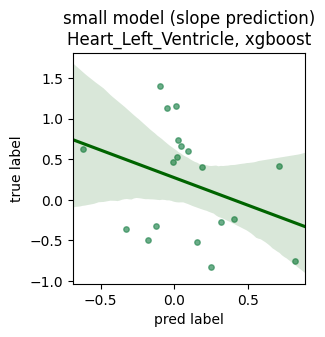

In [5]:
ml_model = model_list[0]
clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators,  max_depth=max_depth) # from grid search

clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [6]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': np.int64(6)}
{'num_leaves': np.int64(14)}


rmse= 0.6574638812786014
r2= -0.07594284537549623
pcc= 0.05971219655452727
pcc_p= 0.8081406428705434


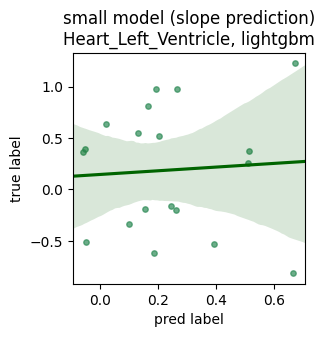

In [7]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': np.int64(94)}
{'max_depth': np.int64(9)}


rmse= 0.6274017893616706
r2= 0.020201185820261314
pcc= 0.15314789817886565
pcc_p= 0.5313500190019153


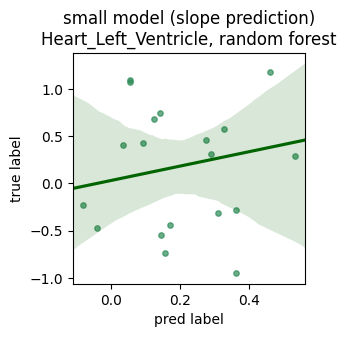

In [9]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)        

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': np.int64(100)}

rmse= 0.632348541359086
r2= 0.004689820642072795
pcc= 0.0770948897219687
pcc_p= 0.7537474168632627


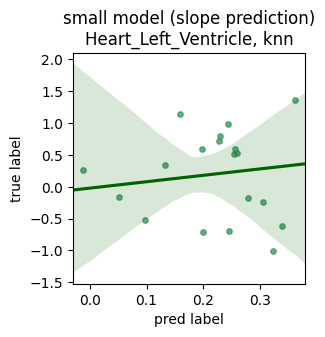

In [11]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)    

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [12]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.01}
{'C': 10}


rmse= 0.634376431400894
r2= -0.0017041720949613204
pcc= -0.20910820517704337
pcc_p= 0.3902530284250721


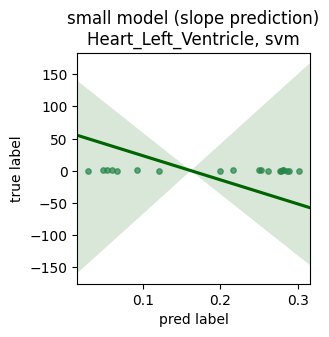

In [13]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)  

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [14]:
model = model_size[1]
train_data = pd.read_pickle(data_path + 'NT_' +  model +  '_train.dataset')
valid_data = pd.read_pickle(data_path + 'NT_' +  model +  '_valid.dataset')
test_data = pd.read_pickle(data_path + 'NT_' +  model +  '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['NT_before'][i].flatten().tolist()
    feature_list += train_data['NT_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['NT_before'][i].flatten().tolist()
    feature_list += test_data['NT_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0  ENSG00000198912.10   chr1_3891607_T_C_b38         -8678  0.237003   
1   ENSG00000158292.6   chr1_6262459_G_C_b38          1484  0.097859   
2  ENSG00000117122.13  chr1_16988930_G_A_b38          8095  0.422018   
3  ENSG00000183431.11  chr1_37997832_C_T_b38          6911  0.397554   
4  ENSG00000162604.12  chr1_61723869_T_C_b38         -1554  0.226300   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0        134      155  1.254417e-46  0.807717  0.046026   
1         61       64  4.483494e-43  1.232429  0.074424   
2        216      276  4.477894e-16  0.309680  0.035791   
3        201      260  8.121680e-28  0.426557  0.034783   
4        131      148  3.871276e-08  0.233419  0.041253   

                                          seq_before  \
0  AACAAAAGAAATTAACAGCAAGCGCGGGGTGGATGTTCAAAAAAAC...   
1  TATCCAGACAGGACCTCGGTCTGCAGGAGCCCCCAGGGCAGCTTGC...   
2  GCTGATGGCCCAGCCAGCCCAGGGCCCATAACCCCCTCCCC

##### model 1: xgboost

In [15]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 3, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 3, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': np.int64(155)}
{'max_depth': np.int64(1)}


rmse= 0.824902976814166
r2= -0.1383147284067643
pcc= 0.07839461883352102
pcc_p= 0.6805047009126437


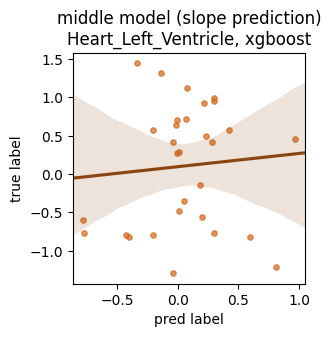

In [16]:
ml_model = model_list[0]

clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [17]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': np.int64(11)}
{'num_leaves': np.int64(14)}


rmse= 0.8532833342214496
r2= -0.2179883664168727
pcc= -0.09203563660085591
pcc_p= 0.6285925628648761


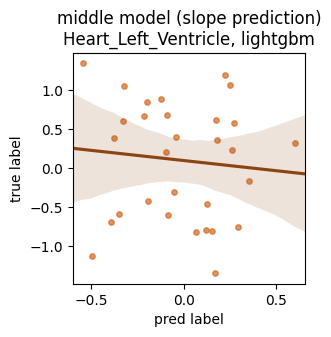

In [18]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': np.int64(10)}
{'max_depth': np.int64(8)}


rmse= 0.8210597102381559
r2= -0.12773250055756646
pcc= -0.03708769787988446
pcc_p= 0.8457274552713819


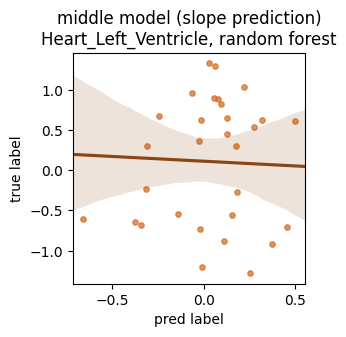

In [20]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)         

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [21]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': np.int64(100)}

rmse= 0.7735241044940615
r2= -0.000931407423313324
pcc= 0.28354711302683855
pcc_p= 0.12890886014789227


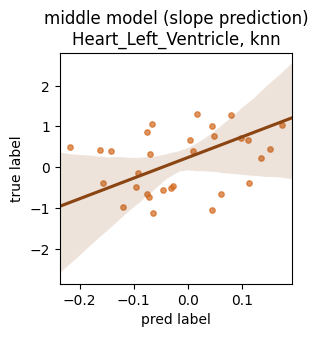

In [22]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)  

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [23]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.01}
{'C': 10}


rmse= 0.7840517064329311
r2= -0.02836200462132954
pcc= 0.014724338635218971
pcc_p= 0.9384440302023438


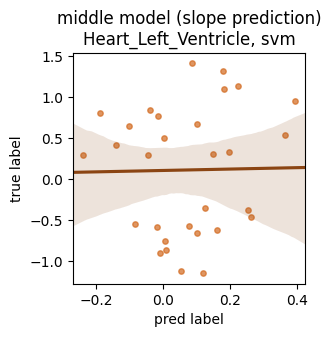

In [24]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)      

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [25]:
model = model_size[2]
train_data = pd.read_pickle(data_path + 'NT_' +  model +  '_train.dataset')
valid_data = pd.read_pickle(data_path + 'NT_' +  model +  '_valid.dataset')
test_data = pd.read_pickle(data_path + 'NT_' +  model +  '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['NT_before'][i].flatten().tolist()
    feature_list += train_data['NT_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['NT_before'][i].flatten().tolist()
    feature_list += test_data['NT_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0  ENSG00000198912.10   chr1_3913050_A_G_b38         12765  0.238532   
1  ENSG00000219481.10  chr1_16577626_T_G_b38        -35936  0.470948   
2  ENSG00000058453.16  chr1_16907772_T_A_b38        -14178  0.223242   
3   ENSG00000204219.9  chr1_23383982_C_T_b38        -40758  0.478593   
4  ENSG00000186501.14  chr1_27335461_C_T_b38         13316  0.012232   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0        135      156  1.310923e-45  0.803954  0.046565   
1        249      308  6.291642e-12  0.370057  0.051472   
2        136      146  1.943628e-24  0.406539  0.036065   
3        229      313  2.416720e-17  0.215370  0.023740   
4          8        8  1.017953e-14  1.098259  0.134080   

                                          seq_before  \
0  ggaagcagtatgtgggatgtgaactgaagtgcacctggaaatcctc...   
1  tatgcgctagggcacctgggggccggcagagccgttcccctacGca...   
2  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

##### model 1: xgboost

In [26]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': np.int64(74)}
{'max_depth': np.int64(9)}


rmse= 0.7207517782546661
r2= -0.4971139826807245
pcc= -0.03995702576031132
pcc_p= 0.8066154346892613


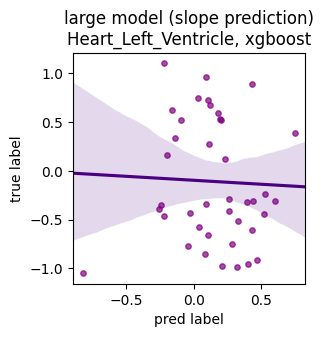

In [27]:
ml_model = model_list[0]

clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [28]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': np.int64(17)}
{'num_leaves': np.int64(14)}


rmse= 0.7653839148848033
r2= -0.6882707001717983
pcc= -0.1129549241534868
pcc_p= 0.4877058451940165


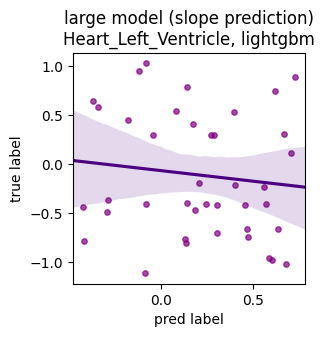

In [29]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)         

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': np.int64(52)}
{'max_depth': np.int64(10)}


rmse= 0.6900170520042763
r2= -0.37215467037371064
pcc= -0.021364714507075718
pcc_p= 0.8958920685425067


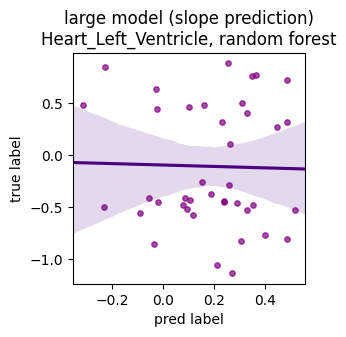

In [31]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [32]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': np.int64(100)}

rmse= 0.6224884062026887
r2= -0.11672427229696525
pcc= 0.08578653562376685
pcc_p= 0.5986596128224877


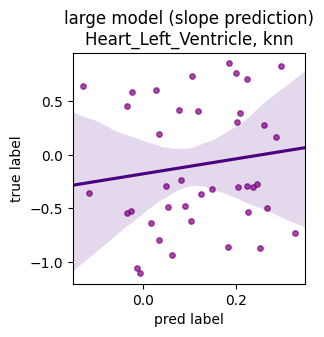

In [33]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [34]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.1}
{'C': 1000}


rmse= 0.6202910499321582
r2= -0.10885421372858795
pcc= -0.17737327360609176
pcc_p= 0.2735407103358061


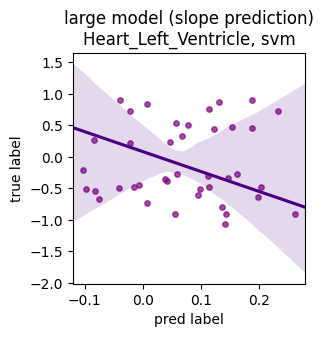

In [35]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)      

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()